<a href="https://colab.research.google.com/github/stsan9/EndoMondoResearchERSP/blob/master/Time_Interval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import the necessary libraries
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import os
import time
import seaborn as sns
sns.set(font_scale=2)
sns.set_color_codes()
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.python.keras.models import load_model

In [0]:
# Mount the google drive file system
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# Load in the data file and store it in a list; data in shared drive
properPath = '/content/gdrive/My Drive/endomondoHR_proper.json' # this may be personalized
properPathSasami = '/content/gdrive/My Drive/EndoMondoData/endomondoHR_proper.json'

data = []
with open(properPathSasami) as f:
    for l in f:
        data.append(eval(l))

In [0]:
# convert to pandas dataframe and drop the unsused columns  
dataframe = pd.DataFrame.from_dict(data)  

In [0]:
# function to extract first element of each list "l"
def begin(l):
  if isinstance(l, list):
      return l[0]

# function to get the mean of only the middle 300 / 500 timestamps in one workout
def mean(l):
  if isinstance(l, list):
    return np.mean(l[100:-100])

In [0]:
# get average heart rate and starting timestamp of all workouts
dataframe['heart_rate'] = dataframe['heart_rate'].apply(mean)
dataframe['timestamp'] = dataframe['timestamp'].apply(begin)

In [0]:
dataframe = dataframe.drop(columns = ["longitude", "altitude", "latitude", "speed", "url", "id", "gender", "sport"])

In [0]:
# filtering out suspicious users based on heart rate
bad_users = dataframe[dataframe['heart_rate'] > 185]
bad_users = dataframe[dataframe['heart_rate'] < 40]
dataframe = dataframe[~dataframe.userId.isin(bad_users['userId'].unique())]

In [0]:
NUM_WORKOUTS = 20
# dataframe now only has users who have more than specified workouts
dataframe = dataframe.groupby("userId").filter(lambda x : len(x) >= NUM_WORKOUTS)

In [0]:
all_users=dataframe["userId"].unique()

In [0]:
for user in all_users:
  user_data = dataframe.loc[dataframe["userId"] == user].sort_values("timestamp")
  arr = np.diff(user_data["timestamp"])
  arr = np.append(arr,[0])
  user_data["timestamp"] = arr.tolist()
  user_data = user_data[0:NUM_WORKOUTS]
  indexNames = dataframe[dataframe["userId"] == user].index
  dataframe.drop(indexNames,inplace=True)
  dataframe = dataframe.append(user_data,ignore_index = True)

dataframe = dataframe.rename( columns= { "timestamp" : "hrs_to_next" } )

In [0]:
def sec_to_hours(secs):
  return math.floor((secs / 60 / 60))

In [0]:
dataframe['hrs_to_next'] = dataframe['hrs_to_next'].apply(sec_to_hours)

In [0]:
# drop users that have > 900 hrs to next workout
bad_users = dataframe.loc[dataframe["hrs_to_next"] > 900]["userId"].unique()
for user in bad_users:
  indexNames = dataframe[dataframe["userId"] == user].index
  dataframe.drop(indexNames, inplace=True)

dataframe = dataframe.reset_index(drop=True)

# drop users that have < 5 hrs to next workout
bad_users = dataframe.loc[dataframe["hrs_to_next"] < 5]["userId"].unique()
for user in bad_users:
  indexNames = dataframe[dataframe["userId"] == user].index
  dataframe.drop(indexNames, inplace=True)

dataframe = dataframe.reset_index(drop=True)

In [0]:
# columns - including all the columns except userId
num_columns = len(dataframe.columns) - 1

In [0]:
# number of unique users
len(dataframe["userId"].unique())

305

In [0]:
# Create an object from the Normalizer class
min_scaler = MinMaxScaler()

In [0]:
# the users in our training data
userids = dataframe['userId'].unique()

In [0]:
dataframe

,heart_rate,hrs_to_next,userId
0,152.546667,72,4007546
1,155.236667,24,4007546
2,147.550000,24,4007546
3,153.350000,46,4007546
4,157.343333,71,4007546
...,...,...,...
6095,123.020000,62,1875839
6096,134.740000,97,1875839
6097,121.393333,95,1875839
6098,124.550000,50,1875839


In [0]:
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [0]:
# baseline for the rnn, the mse error if the predicted values is the mean of previous workouts
error_sq = [] # list of error values per user

# adds the squared difference of the average per user
for user in dataframe['userId'].unique():
  user_x = dataframe.loc[dataframe["userId"] == user]

  for i in range(11): # implement sliding window
    avg_hr = np.average(user_x.iloc[0+i: 9+i]['hrs_to_next'])
    error_sq += [(np.log(user_x.iloc[9+i]['hrs_to_next']) - np.log(avg_hr)) ** 2]

dummy_mse = np.average(error_sq) # the final MSE value
print('Baseline MSE for hours: ' + str(dummy_mse))

Baseline MSE for hours: 0.7654247881055768


In [0]:
# build the model (1 LSTM layer and 1 output layer)
model = Sequential()

model.add(GRU(units = 32, return_sequences=False, input_shape = (None, num_columns,)))
model.add(Dropout(0.1))
#model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

#optimizer = tf.keras.optimizers.RMSprop(lr=1e-3) #low learning rate, could change this as well

model.compile(loss='mean_squared_error', optimizer='adam')  # using mse loss function

In [0]:
epochs = 1000
batch_size = 10
num_users = len(userids)
window_size = 10
sequence_length = 20

for e in range(epochs):
  np.random.shuffle(userids)

  # initialize batches
  x_shape = (num_users*10, window_size, num_columns)
  y_shape = (num_users*10, 1)
  x_batch = np.zeros(shape=x_shape, dtype=np.float16)
  y_batch = np.zeros(shape=y_shape, dtype=np.float16)

  for b in range(num_users):
    # grab 20 workouts from the user
    x = dataframe[b * sequence_length : (b + 1) * sequence_length - 1]
    x = x.drop(columns=['heart_rate', "userId"])
    x = x.values

    # creates sliding windows for those workouts
    sliding_window_x = rolling_window(x, window_size)

    for i in range(sliding_window_x.shape[0]):  # put each window into batch
      y = dataframe.loc[[(b+1)*window_size+i]]
      y = y.hrs_to_next
      y = np.log(y, where = y > 0)
      x_batch[sliding_window_x.shape[0]*b+i] = sliding_window_x[i]
      y_batch[sliding_window_x.shape[0]*b+i] = y

  model.fit(x_batch, y_batch, batch_size=batch_size)  # after 1000 epochs it hovers around loss: 0.69

Train on 3050 samples
3050/3050 [==============================] - 9s 3ms/sample - loss: 2.6251
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9804
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9681
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9520
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9628
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9251
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9226
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9061
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.9123
Train on 3050 samples
3050/3050 [==============================] - 6s 2ms/sample - loss: 0.8960
Train on 3050 samples
3050/3050 [=======

KeyboardInterrupt: ignored

In [0]:
#adjust these values depending on the model inputs
sequence_length = 20
num_users = len(dataframe['userId'].unique())
num_columns = 2 # columns - 21 refers to including all the columns except userId
predictions = []
actual = []
placement = []

for b in range(num_users):
  x = dataframe[b * sequence_length : (b + 1) * sequence_length - 1]
  x = x.drop(columns=["userId"])
  x = x.values
  test_shape = (1, sequence_length - 1, num_columns)
  test_batch = np.zeros(shape=test_shape, dtype=np.float16)
  test_batch[0] = x
  p = model.predict(test_batch)
  predictions.append(np.exp(p[0][0]))
  actual.append(dataframe.loc[[(b + 1) * sequence_length - 1]]["hrs_to_next"].iloc(0)[0])
  placement.append(b)

num_type = ['Predicted' if x < len(predictions) else 'Actual' for x in range(len(predictions) + len(actual))]
placement += placement

In [0]:
cols = ['placement', 'value', 'num_type']
vis_df = pd.DataFrame(columns = cols)
vis_df['placement'] = placement
vis_df['value'] = predictions + actual
vis_df['num_type'] = num_type
vis_df

,placement,value,num_type
0,0,51.920872,Predicted
1,1,88.343582,Predicted
2,2,77.210739,Predicted
3,3,38.082825,Predicted
4,4,59.896866,Predicted
...,...,...,...
605,300,125.000000,Actual
606,301,92.000000,Actual
607,302,68.000000,Actual
608,303,42.000000,Actual


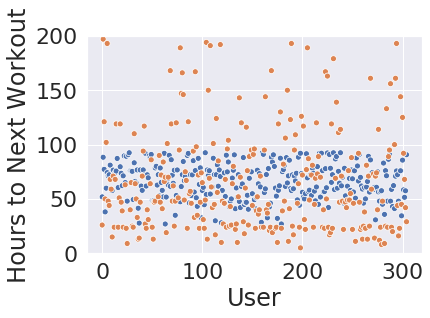

In [0]:
model_scatter = (sns.scatterplot(x="placement", y="value", hue="num_type",
                                 legend=False, data=vis_df)) #Blue is predicted and Orange is actual
model_scatter.set(xlabel='User', ylabel='Hours to Next Workout')
model_scatter.set(ylim=(0, 200))
plt.show()

In [0]:
vis_df = pd.DataFrame(columns = ['Actual', 'Predicted', 'Squared Difference'])
vis_df['Actual'] = actual
vis_df['Predicted'] = predictions
vis_df['Squared Difference'] = [(np.log(actual[x]) - np.log(predictions[x])) ** 2 for x in range(305)]
vis_df['Placement'] = placement[0:305]
vis_df

,Actual,Predicted,Squared Difference,Placement
0,26,51.920872,0.478344,0
1,197,88.343582,0.643156,1
2,121,77.210739,0.201827,2
3,50,38.082825,0.074125,3
4,102,59.896866,0.283395,4
...,...,...,...,...
300,125,85.703842,0.142443,300
301,92,58.349571,0.207331,301
302,68,51.523651,0.076988,302
303,42,57.495316,0.098617,303


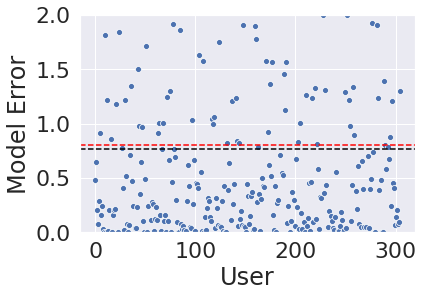

In [0]:
error_scatter = (sns.scatterplot(x="Placement", y="Squared Difference", 
                                 legend=False, data=vis_df)) #Blue is predicted and Orange is actual

error_scatter.set(xlabel='User', ylabel='Model Error')
error_scatter.set(ylim=(0, 2))

error_scatter.axhline(dummy_mse, ls='--', color='black')
error_scatter.axhline(0.8068, ls='--', color='red')

plt.show()

In [0]:
 # predictions vs actual
for b in range(num_users):
  for i in range(11):
    x = dataframe[b * window_size + i : (b + 1) * window_size - 1 + i]
    x = x.drop(columns=['heart_rate', "userId"])
    x = x.values
    test_shape = (1, window_size - 1, num_columns)
    test_input = np.zeros(shape=test_shape, dtype=np.float16)
    test_input[0] = x
    p = model.predict(test_input) # the prediction
    print ("pred : " + str(np.exp(p[0][0])) + " | y: " + str(dataframe.loc[[(b + 1) * window_size - 1 + i]]["hrs_to_next"].iloc(0)[0]))

pred : 80.75981 | y: 26
pred : 63.136734 | y: 29
pred : 68.675766 | y: 39
pred : 58.520683 | y: 97
pred : 76.5112 | y: 25
pred : 64.03608 | y: 45
pred : 72.376335 | y: 72
pred : 62.790596 | y: 24
pred : 76.99753 | y: 70
pred : 72.06176 | y: 72
pred : 67.00123 | y: 26
pred : 67.00123 | y: 26
pred : 65.0938 | y: 56
pred : 82.21632 | y: 111
pred : 70.49503 | y: 168
pred : 58.0992 | y: 295
pred : 67.12656 | y: 65
pred : 70.53656 | y: 144
pred : 51.460793 | y: 312
pred : 66.00542 | y: 337
pred : 51.06854 | y: 167
pred : 50.185047 | y: 117
pred : 50.185047 | y: 117
pred : 51.425888 | y: 120
pred : 51.565838 | y: 24
pred : 47.919594 | y: 74
pred : 68.537025 | y: 817
pred : 59.3814 | y: 43
pred : 54.339954 | y: 339
pred : 50.64199 | y: 314
pred : 50.64199 | y: 186
pred : 48.822662 | y: 169
pred : 48.786274 | y: 197
pred : 48.786274 | y: 197
pred : 55.0665 | y: 167
pred : 63.67065 | y: 27
pred : 51.73416 | y: 118
pred : 64.15448 | y: 357
pred : 63.098724 | y: 335
pred : 63.098724 | y: 167
pred 

KeyboardInterrupt: ignored

Still need to:
- Add callbacks (save the model after training) - SRAVYA 
- Extract a validation set from the current training set - SRAVYA
- Extract a training set and testing set from the current set - ANDRES
- Evaluate the model and experiment with adding back in other contextual variables
- Modify the data and RNN to output a timestamp as well
- Visualize our RNN's predictions